In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyedflib
import mne
import neurokit2 as nk2
import p_tqdm
from scipy.stats import trim_mean
from scipy import signal
from scipy.optimize import least_squares
import statsmodels.api as sm
from collections import defaultdict
import wfdb

#)It includes a general alignment to synchronize heart beats from a resting period by finding similar patterns 
    #in all devices and the correction of incorrect and unsteady sampling frequencies by non-linear 
    #resampling to a target sampling frequency of 256 Hz
    
#Must align data by synchronizing heartbeats from a resting period
    #Must fix incorrect sampling frequencies by non-linear resampling to a target sampling frequency of 256 Hz

In [ ]:
signal, fields = wfdb.rdsamp('x001')
header=fields['sig_name']
desired_result=pd.DataFrame(data=signal, columns=header)

In [55]:
s1_polar=pd.read_csv('/Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_POLAR.hrm', 
                     on_bad_lines='skip', names=['R-R Interval (ms)'])
edf_HX = mne.io.read_raw_edf('x001_HX.edf')
edf_NEXUS=mne.io.read_raw_edf('x001_NEXUS.edf')
edf_SOT=mne.io.read_raw_edf('x001_SOT.edf')
edf_FAROS=mne.io.read_raw_edf('x001_FAROS.edf')

Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_FAROS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [805]:
edf_HX = mne.io.read_raw_edf('x001_HX.edf')
edf_HX=edf_HX.to_data_frame()

edf_NEXUS=mne.io.read_raw_edf('x001_NEXUS.edf')
edf_NEXUS_df=edf_NEXUS.to_data_frame()
edf_NEXUS_df['Sensor-B:EKG']=edf_NEXUS_df['Sensor-B:EEG']
edf_NEXUS_df=edf_NEXUS_df.drop(columns='Sensor-B:EEG') #Removing misnamed column

edf_SOT=mne.io.read_raw_edf('x001_SOT.edf')
edf_SOT_df=edf_SOT.to_data_frame()

edf_FAROS=mne.io.read_raw_edf('x001_FAROS.edf')
edf_FAROS_df=edf_FAROS.to_data_frame()

Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_FAROS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [824]:
ECG_1=edf_HX.iloc[:,:2]
ECG_2=edf_NEXUS_df.iloc[:,:3]
ECG_3=edf_SOT_df.iloc[:,:3]
ECG_4=edf_FAROS_df.iloc[:,:2]

In [73]:
b,a =signal.butter(2,(2.5,20), btype='bandpass', fs=256)

#N(Order of filter): hard to explain, intensity of filter between 2-4
#Wn: Scalar or tuple (for bandpass) frequency to cut off the data
#fs=sampling frequency
#btype='high'/'low'/'bandpass'

In [34]:
ecg_1=ECG_1['4113:ECG_I'].to_numpy()
ecg_2=ECG_2['Sensor-B:EKG'].to_numpy()
ecg_3=ECG_3['EKG 3'].to_numpy()
ecg_4=ECG_4['ECG'].to_numpy()

time_1=ECG_1['time']
time_2=ECG_2['time']
time_3=ECG_3['time']
time_4=ECG_4['time']

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


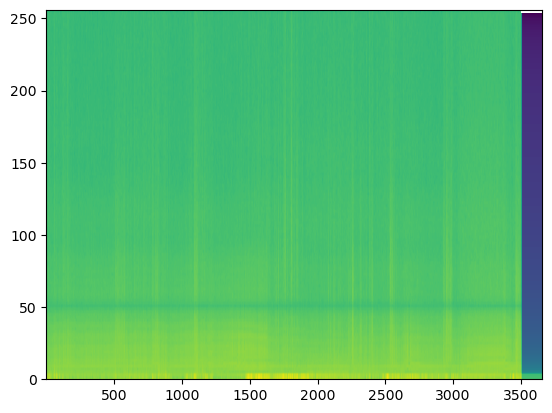

NameError: name 'time_1' is not defined

In [35]:
#Signal Processing Worklflow
    #1. Specgram to view the data

plt.specgram(ecg_3, Fs=512) #Green is some signal, yellow is string, blue is none...lots of noise masquearding as signal
    #in yellow
plt.ylim() #Most wearable ECG signals between 4-16 Hz
plt.show()

    #2. Develop Filter based off of Specgram
b,a =signal.butter(2,(2.5,20), btype='bandpass', fs=512)
filtered = signal.filtfilt(b, a, ecg_3)

    #3. #Standardization of data to unitless signal

unit_less_signal= (filtered - np.mean(filtered)) / np.std(filtered)

plt.plot(time_1[256:2560], filtered[256:2560])
plt.show()

In [36]:
ECGs=[ecg_1, ecg_2, ecg_3, ecg_4]
srs=[256, 256, 512, 1000]

annotations=[]

for i,x in zip(ECGs, srs):
    signals, info =nk2.ecg_process(i, sampling_rate=x)
    annotation=info['ECG_R_Peaks']
    annotations.append(annotation)

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


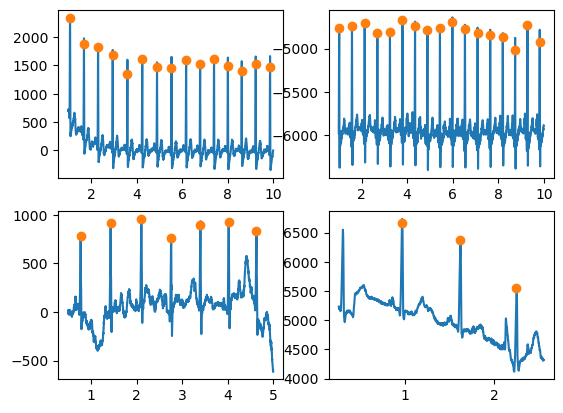

In [37]:
range_annotations=[]

for i in annotations:
    annotations_x=i[(i<2560) & (i>=256)] 
    range_annotations.append(annotations_x)
    
fig, ax=plt.subplots(2,2)    
ax[0,0].plot(time_1[256:2560], ecg_1[256:2560])
ax[0,0].plot(time_1[range_annotations[0]], ecg_1[range_annotations[0]], 'o')
ax[0,1].plot(time_2[256:2560], ecg_2[256:2560])
ax[0,1].plot(time_2[range_annotations[1]], ecg_2[range_annotations[1]], 'o')
ax[1,0].plot(time_3[256:2560], ecg_3[256:2560])
ax[1,0].plot(time_3[range_annotations[2]], ecg_3[range_annotations[2]], 'o')
ax[1,1].plot(time_4[256:2560], ecg_4[256:2560])
ax[1,1].plot(time_4[range_annotations[3]], ecg_4[range_annotations[3]], 'o')
plt.show() #Awesome, just need to do this now for all the filtered data.

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


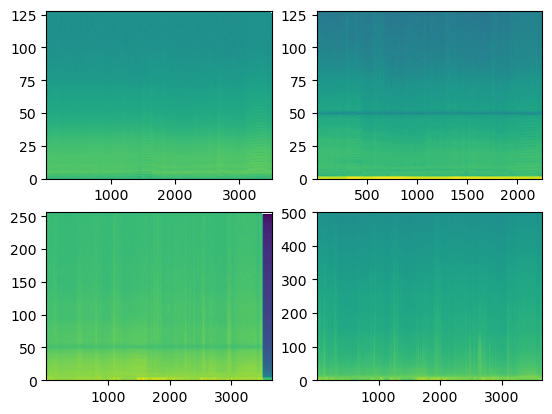

In [38]:
fig,ax=plt.subplots(2,2)
ax[0,0].specgram(ecg_1, Fs=256)
ax[0,1].specgram(ecg_2, Fs=256)
ax[1,0].specgram(ecg_3, Fs=512)
ax[1,1].specgram(ecg_4, Fs=1000)
plt.ylim() #Most wearable ECG signals between 4-16 Hz
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

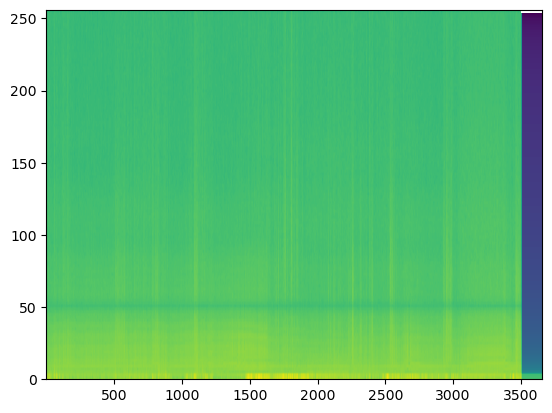

In [94]:
plt.specgram(ecg_3, Fs=512)
plt.show #Simply means there is no signal at that timepoint anymore

In [1075]:
b,a =signal.butter(2,(5,50), btype='bandpass', fs=512)
filtered = signal.filtfilt(b, a, idiot)

unit_less_signal= (filtered - np.mean(filtered)) / np.std(filtered)

In [1076]:
unit_less_signal=unit_less_signal[:cut]

In [1037]:
unit_less_signal=nk2.signal_resample(unit_less_signal, desired_length=len(ECG_1), desired_sampling_rate=256)

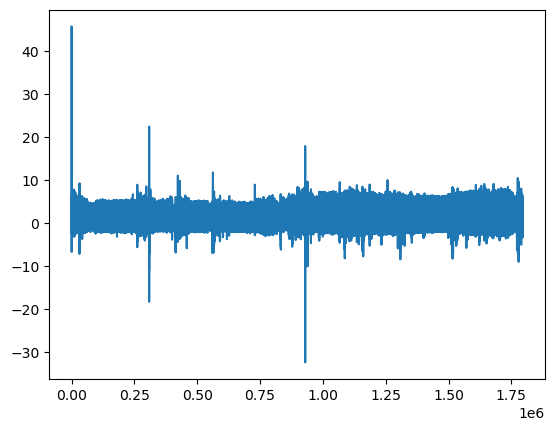

In [1077]:
plt.plot(unit_less_signal)

In [1039]:
unit_less_signal=pd.Series(unit_less_signal)

In [1006]:
upper_bound=desired_result_sot.max()
lower_bound=desired_result_sot.min()

result=unit_less_signal[(unit_less_signal >= lower_bound) & (unit_less_signal <= upper_bound)]

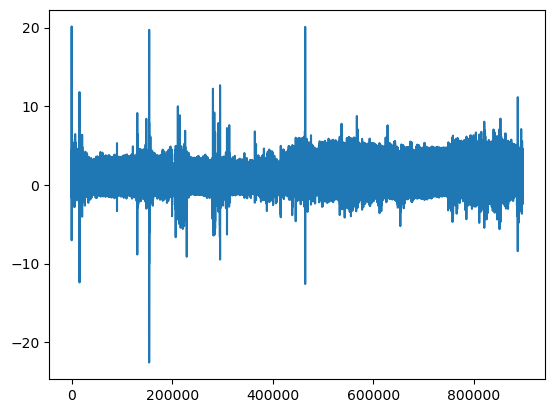

In [1008]:
plt.plot(result)

In [1018]:
result

0         -0.603149
1         10.776830
19        20.146601
20        18.315416
21        16.685020
            ...    
896507     0.633756
896508     0.588688
896509     0.510794
896510     0.393636
896511     0.000000
Length: 896459, dtype: float64

In [1014]:
desired_result_sot.argmax()

160595

In [995]:
desired_result['SOT/EKG_filtered'].max()

21.065883609439922

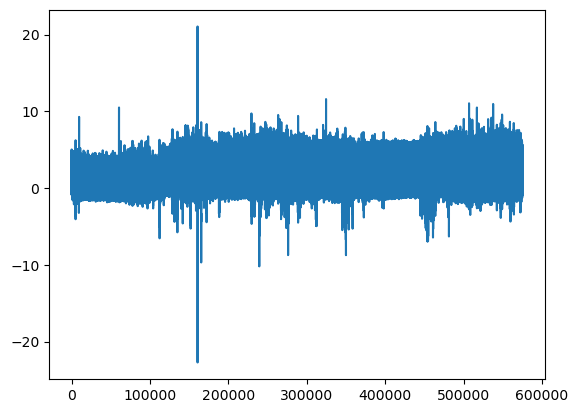

In [970]:
plt.plot(desired_result_sot)

In [40]:
range_annotations

[array([ 276,  432,  591,  755,  920, 1087, 1253, 1416, 1580, 1738, 1894,
        2049, 2205, 2362, 2523]),
 array([ 260,  404,  547,  689,  831,  972, 1112, 1252, 1392, 1532, 1673,
        1815, 1957, 2098, 2237, 2376, 2513]),
 array([ 395,  732, 1077, 1411, 1740, 2058, 2370]),
 array([ 966, 1621, 2253])]

In [108]:
unit_less_annotations

[array([   121,    276,    432, ..., 895764, 895929, 896150]),
 array([   115,    260,    404, ..., 574844, 575002, 575225]),
 array([    394,     731,    1076, ..., 1795323, 1795649, 1795968]),
 array([    966,    1620,    2252, ..., 3649221, 3650140, 3651143])]

In [101]:
unit_less_annotations=[]

for i,x in zip(unitless_signals, srs):
    signals, info =nk2.ecg_process(i, sampling_rate=x)
    annotation=info['ECG_R_Peaks']
    unit_less_annotations.append(annotation)
    
bounded_sensor_annotations=[]

for i in unit_less_annotations:
    annotations_x=i[(i<2560) & (i>=256)] 
    bounded_sensor_annotations.append(annotations_x)
    
#Filter all the Data to create unitless ECG...same with unitless annotations or otherwise

fig, ax=plt.subplots(2,2)    
ax[0,0].plot(time_1[256:2560], unitless_signals[0][256:2560])
ax[0,0].plot(time_1[bounded_sensor_annotations[0]], unitless_signals[0][bounded_sensor_annotations[0]], 'o')
ax[0,1].plot(time_2[256:2560], unitless_signals[1][256:2560])
ax[0,1].plot(time_2[bounded_sensor_annotations[1]], unitless_signals[1][bounded_sensor_annotations[1]], 'o')
ax[1,0].plot(time_3[256:2560], unitless_signals[2][256:2560])
ax[1,0].plot(time_3[bounded_sensor_annotations[2]], unitless_signals[2][bounded_sensor_annotations[2]], 'o')
ax[1,1].plot(time_4[256:2560], unitless_signals[3][256:2560])
ax[1,1].plot(time_4[bounded_sensor_annotations[3]], unitless_signals[3][bounded_sensor_annotations[3]], 'o')
plt.show()

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


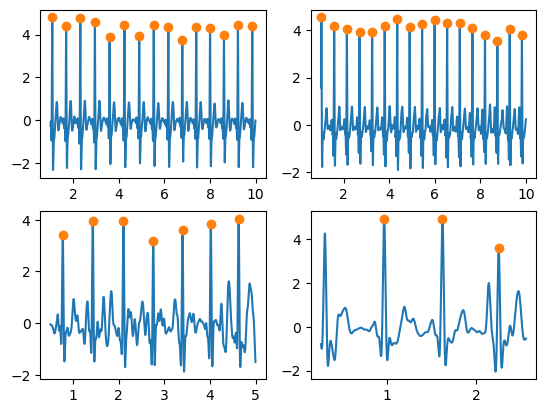

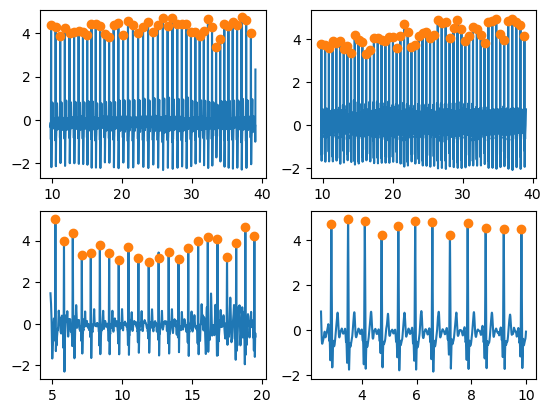

In [42]:
#Examining a different segment to see if the annotations line up with the signal

range_annotations=[]

for i in annotations:
    annotations_x=i[(i<10000) & (i>=2500)] 
    range_annotations.append(annotations_x)

unitless_signals=[]

for i,x in zip(ECGs, srs):
    b,a =signal.butter(3,(2.5,20), btype='bandpass', fs=x)
    filtered = signal.filtfilt(b, a, i)
    unitless_signal= (filtered - np.mean(filtered)) / np.std(filtered)
    unitless_signals.append(unitless_signal)

fig, ax=plt.subplots(2,2)    
ax[0,0].plot(time_1[2500:10000], unitless_signals[0][2500:10000])
ax[0,0].plot(time_1[range_annotations[0]], unitless_signals[0][range_annotations[0]], 'o')
ax[0,1].plot(time_2[2500:10000], unitless_signals[1][2500:10000])
ax[0,1].plot(time_2[range_annotations[1]], unitless_signals[1][range_annotations[1]], 'o')
ax[1,0].plot(time_3[2500:10000], unitless_signals[2][2500:10000])
ax[1,0].plot(time_3[range_annotations[2]], unitless_signals[2][range_annotations[2]], 'o')
ax[1,1].plot(time_4[2500:10000], unitless_signals[3][2500:10000])
ax[1,1].plot(time_4[range_annotations[3]], unitless_signals[3][range_annotations[3]], 'o')
plt.show()

In [43]:
R_R_intervals = []
for i, x in zip(annotations, srs):
    diffs = np.diff(i) / x
    R_R_intervals.append(diffs)

In [44]:
#After that, intervals suspected to be adjacent to irregular heart beats or unreasonable intervals in noisy segments 
    #were removed from the interval sequence by NaN-replacement...filtered using relative R_R interval approach
    #check paper
    
R_R_intervals

[array([0.609375  , 0.62109375, 0.640625  , ..., 0.640625  , 0.64453125,
        0.94140625]),
 array([0.5625    , 0.5625    , 0.55859375, ..., 0.6328125 , 0.61328125,
        0.62890625]),
 array([0.65820312, 0.67382812, 0.65234375, ..., 0.59765625, 0.70117188,
        0.625     ]),
 array([0.655, 0.632, 0.624, ..., 0.623, 0.627, 1.915])]

In [45]:
ecg_1=unitless_signals[0]
ecg_2=unitless_signals[1]
ecg_3=unitless_signals[2]
ecg_4=unitless_signals[3]

In [47]:
#Manually trying to remove noise would be a pain
ecg_4[3658000:]

#Use Math to Code approach for relative rr intervals....see paper

rri=[]
for i in range(1, len(R_R_intervals[0])):
    r_r_i=(R_R_intervals[0][i]-R_R_intervals[0][i-1])/(0.5*(R_R_intervals[0][i]+R_R_intervals[0][i-1]))
    rri.append(r_r_i)
    
rri_2=[]
for i in range(1, len(R_R_intervals[1])):
    r_r_i=(R_R_intervals[1][i]-R_R_intervals[1][i-1])/(0.5*(R_R_intervals[1][i]+R_R_intervals[1][i-1]))
    rri_2.append(r_r_i)

In [49]:
rri_3=[]
for i in range(1, len(R_R_intervals[2])):
    r_r_i=(R_R_intervals[2][i]-R_R_intervals[2][i-1])/(0.5*(R_R_intervals[2][i]+R_R_intervals[2][i-1]))
    rri_3.append(r_r_i)
    
rri3=pd.Series(rri_3)

rri_4=[]
for i in range(1, len(R_R_intervals[3])):
    r_r_i=(R_R_intervals[3][i]-R_R_intervals[3][i-1])/(0.5*(R_R_intervals[3][i]+R_R_intervals[3][i-1]))
    rri_4.append(r_r_i)
    
rri4=pd.Series(rri_4)

In [50]:
R_R_intervals[0].min() #R_R intervals all positive 

0.4140625

In [52]:
np.array(rri).min() #relative R_R interval is measure of change in R_R which can be negative

-0.07909604519774012

In [56]:
s1_polar

,R-R Interval (ms)
0,[Params]
1,Version=106
2,Monitor=37
3,SMode=000000000
4,Date=20010101
...,...
5744,589
5745,580
5746,579
5747,582


In [57]:
polar_r_r=s1_polar.drop(index=range(0,45))
result = polar_r_r.apply(pd.api.types.is_string_dtype)

string_indexes = result.where(result==True)

In [61]:
polar_r_r=polar_r_r.reset_index(drop=True)

polar_r_r=polar_r_r[13:]

In [62]:
polar_r_r

,R-R Interval (ms)
13,613
14,604
15,610
16,611
17,612
...,...
5699,589
5700,580
5701,579
5702,582


In [301]:
R_R_intervals[0].min()

0.4140625

In [308]:
polar=polar_r_r.values.reshape(-1)

In [313]:
x=613

In [325]:
polar=polar.astype('float64')

In [327]:
polar=polar/1000

In [310]:
R_R_intervals.append(polar)

In [328]:
R_R_intervals.pop(-1)

array(['613', '604', '610', ..., '579', '582', '594'], dtype=object)

In [330]:
R_R_intervals.append(polar)

In [331]:
R_R_intervals #Got all the R_R intervals including polar

[array([0.609375  , 0.62109375, 0.640625  , ..., 0.640625  , 0.64453125,
        0.94140625]),
 array([0.5625    , 0.5625    , 0.55859375, ..., 0.6328125 , 0.61328125,
        0.62890625]),
 array([0.65820312, 0.67382812, 0.65234375, ..., 0.59765625, 0.70117188,
        0.625     ]),
 array([0.655, 0.632, 0.624, ..., 0.623, 0.627, 1.915]),
 array([0.613, 0.604, 0.61 , ..., 0.579, 0.582, 0.594])]

In [68]:
hexoskin_filtered=unitless_signals[0]

In [72]:
#Alignment of Multi_Sensored Data...
    #Hexoskin’s ECG was used as the reference ECG channel to which all other sensors were aligned to...ecg1
    
ECG_1

,time,4113:ECG_I
0,0.000000,1900.842412
1,0.003906,-8697.550007
2,0.007812,-8703.950002
3,0.011719,-8703.950002
4,0.015625,-8703.950002
...,...,...
896507,3501.980469,-8703.950002
896508,3501.984375,-8703.950002
896509,3501.988281,-8703.950002
896510,3501.992188,-8703.950002


In [73]:
#We performed the alignment of RR interval sequences by searching for the best local alignment of a 
    #short segment of 300 beats from a resting state period (sequence with lowest heart rate)
    
    
    #Start with finding period of lowest heart rate, then align R_R intervals based on best local alignment of 300
        #beat segment
        
#Finding period of lowest heart rate

heart_rates=[]

for i,x in zip(ECGs, srs):
    signals, info =nk2.ecg_process(i, sampling_rate=x)
    hr=signals['ECG_Rate']
    heart_rates.append(hr)
    
heart_rates_2=[]
for i,x in zip(heart_rates, srs):
    heart_rate=i[::x]
    heart_rates_2.append(heart_rate)

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


In [74]:
heart_rates_2 #Filter out data at the end of entries 2 and 3 due to error.


#Pop off the last 150 entries of heart_rates_2[2] and the last 8 entries of heart_rates_2[3]
heart_rates_2[2]=heart_rates_2[2][:-149]
heart_rates_2[3]=heart_rates_2[3][:-8]

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/927263020.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  heart_rates_2[2]=heart_rates_2[2][:-149]
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/927263020.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  heart_rates_2[3]=heart_rates_2[3][:-8]


In [76]:
lens=[int(len(i)/4) for i in heart_rates_2] #Divided by 4 given there were 4 periods of 'load'
numbers=[1,2,3,4]

sub_dict=defaultdict(dict)

for i,x,z in zip(heart_rates_2, lens, numbers):
    sensor=[]
    sensor.append(i[:x].mean())
    sensor.append(i[x:x*2].mean())
    sensor.append(i[x*2:x*3].mean())
    sensor.append(i[x*3:x*4].mean())
    sub_dict[f"Sensor_{z}"]=sensor #Looks like the 3rd batch is the batch with the lowest heart rate in average

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/1553004234.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sensor.append(i[:x].mean())
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/1553004234.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sensor.append(i[x:x*2].mean())
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/1553004234.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated

In [77]:
sub_dict

defaultdict(dict,
            {'Sensor_1': [98.55155978333119,
              107.87984079333647,
              93.33278823945136,
              111.72891356213118],
             'Sensor_2': [112.49644928201045,
              92.10688412876094,
              99.24413638796234,
              116.97556343949756],
             'Sensor_3': [98.56069808526807,
              107.78369881700485,
              93.39854684010633,
              111.6162499178337],
             'Sensor_4': [97.55722802006164,
              108.5253986113659,
              93.28199270711885,
              111.00745180113715]})

In [460]:
#Align RR intervals by searching for the best local alignment of a short segment of 300 beats from 
    #the third period=heart_rates_2[i][len(i)/4*2:len(i)/4*3]
    #Once you find the best local alignment you know how to shift the R_R intervals
    
third_period_0=heart_rates_2[0][len(heart_rates_2[0])//4*2:len(heart_rates_2[0])//4*3]

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_22652/2695699298.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  third_period_0=heart_rates_2[0][len(heart_rates_2[0])//4*2:len(heart_rates_2[0])//4*3]


In [84]:
best_alignment_300_beats=[]
for idx,i in enumerate(R_R_intervals):
    fixed=R_R_intervals[idx][len(R_R_intervals[idx])//4*2:len(R_R_intervals[idx])//4*3]
    best_alignment_300_beats.append(fixed)

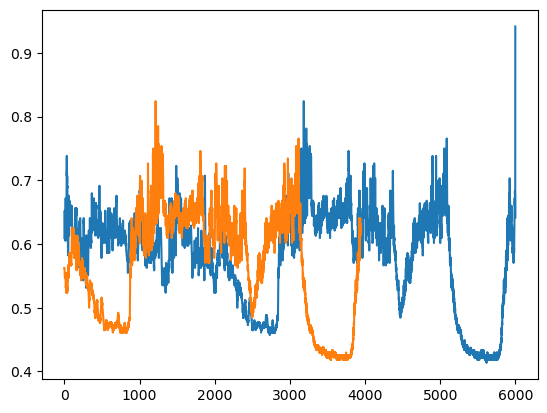

In [89]:
plt.plot(R_R_intervals[0]) #offset, time to fix them with function
plt.plot(R_R_intervals[1])
plt.show()

In [182]:
#Gradient Descent-ish method with 300 at a time...use middle 300 instead of argmin/argmax because the min could be far
    #off the end of graph and not fully captured in the window..keeping code to reference later

minimum_index_1=pd.Series(sensor_1_third_period).rolling(300).mean().argmin()
minimum_index_2=pd.Series(sensor_2_third_period).rolling(300).mean().argmin()
minimum_index_3=pd.Series(sensor_3_third_period).rolling(300).mean().argmin()
minimum_index_4=pd.Series(sensor_4_third_period).rolling(300).mean().argmin()

In [90]:
#Define a function that aligns the ECG_data on the reference window and then plots the final outputs

def multi_sensor_alignment(reference_sensor, sensor_2, manual_shift=None):
    
    #Establish a reference window starting from the index in the middle of the reference signal
    mid_point=len(reference_sensor)//2
    reference_index=[mid_point-150, mid_point+150]
    start=reference_index[0]
    reference_window=range(start, start+300)
    
    #Find the minimum MAE for each possible window of across the sensors
    maes=[]
    window_length=300
    for i in range(1, len(sensor_2)):
        try:
            window=sensor_2[i:i+window_length]
            difference=abs(reference_sensor[reference_window]-window)
            mae=np.mean(difference)
            maes.append(mae)
        except:
            pass
    index=np.argmin(maes)
    
    #Establish Shift
    shift=(reference_window[0]-index)
    if manual_shift==None:
        pass
    if manual_shift!=None:
        shift=manual_shift
    
    #Develop Dataframe from Data and shift data accordingly
    df=pd.DataFrame(data=[reference_sensor, sensor_2]).T
    df[1]=df[1].shift(shift)
    
    aligned_signals=df
    
    
    #plot shifted data and OG data to see comparison
    fig,ax=plt.subplots(1,2)
    ax[0].plot(reference_sensor)
    ax[0].plot(sensor_2)
    ax[1].plot(df)
    plt.show()
    
    return aligned_signals

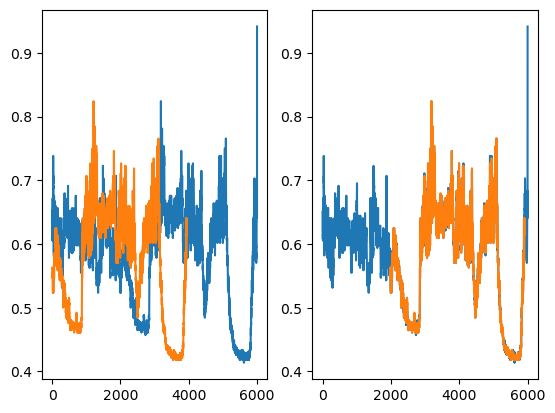

In [93]:
signals_0_1=multi_sensor_alignment(R_R_intervals[0], R_R_intervals[1])

In [45]:
#Very similar to what Tanuj and I did, I was simply trying to do it with correlation matrix and 300 points at a time.
    #I can try both now that I know the implementation

test_1=[xs[0], xs[1]]
test_2=[ys[0], ys[1]]
[np.corrcoef(i,x) for i,x in zip(test_1, test_2)] #Got a correlation here for these 300 segments...Need to modify to
        #iterate through the lists in their entirety and then select the 300 beats that are most closely related

[array([[ 1.        , -0.28013019],
        [-0.28013019,  1.        ]]),
 array([[1.        , 0.04743928],
        [0.04743928, 1.        ]])]

In [231]:
#Same technique but done with correlation coefficient

coeffs=[]
step=300
for i in range(1, len(sensor_3_third_period)):
    #create a 300 long window
    try:
        window=sensor_3_third_period[i:i+300]
    #subtract the 300 long window from the reference window and calculate MAE
        cor_cof=np.corrcoef(sensor_1_third_period[reference_window], window)[0][1]
        coeffs.append(cor_cof)
    except:
        pass

In [234]:
np.max(coeffs)

0.9568872660244702

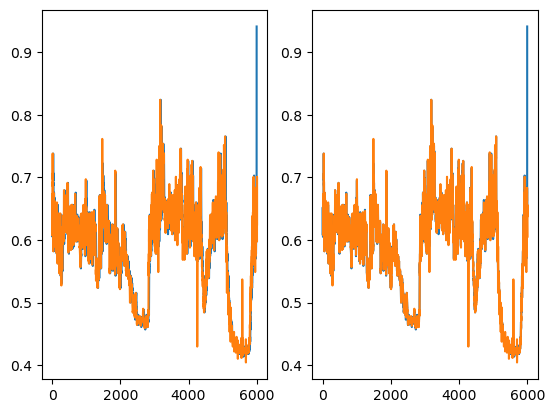

In [98]:
signals_0_2=multi_sensor_alignment(R_R_intervals[0], R_R_intervals[2])

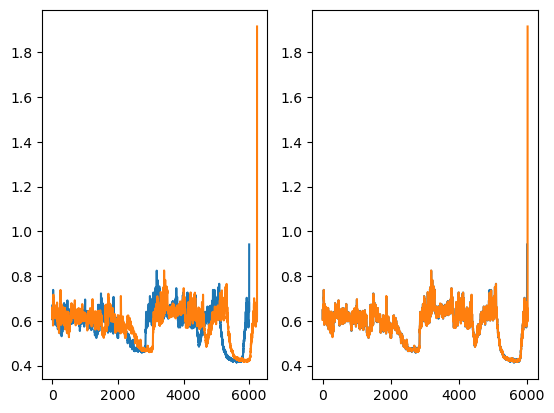

In [104]:
signals_0_3=multi_sensor_alignment(R_R_intervals[0], R_R_intervals[3])

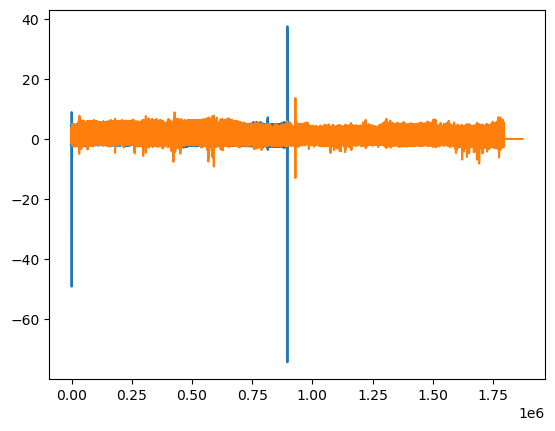

In [338]:
plt.plot(ecg_1) #Have to plot and align on R_R intervals because different devices have different sample rates so
#cannot align with different sampling rates
plt.plot(ecg_3)
plt.show()

In [567]:
results.params #first value is constant b0 and second value is slope

array([ 0.72764913, -0.15420429])

In [566]:
#Step 3: Linear Correction of Sampling Frequencies...this was done before previous alignment task (8000-8192) for 
    #subjects 4-13. Earlier subject 1-3 had incorrect 256 sampling rate which resulted in some missing data
    
#We therefore corrected the sampling frequency of the second sensor. This was done by computing the slope of a robust
    #linear regression fit from the 300 matched beats of the resting period.
    
x=sensor_1_third_period[reference_window]
y=sensor_2_third_period[684:984]

x = sm.add_constant(x)

# Use the HuberT loss function, bisquare weighting function
model = sm.RLM(y, x, M=sm.robust.norms.HuberT())
results = model.fit()

slope=results.params[1]

In [404]:
slope

-0.1542042895051674

In [405]:
# fs = fs · (1 − b) 

fs=256*(1-slope)

In [406]:
fs #for the second sensor

295.47629811332285

In [376]:
#Have to calculate continuous beat to beat differences between the time_shifted data and the reference
    #signal
    
R_R_intervals

[array([0.609375  , 0.62109375, 0.640625  , ..., 0.640625  , 0.64453125,
        0.94140625]),
 array([0.5625    , 0.5625    , 0.55859375, ..., 0.6328125 , 0.61328125,
        0.62890625]),
 array([0.65820312, 0.67382812, 0.65234375, ..., 0.59765625, 0.70117188,
        0.625     ]),
 array([0.655, 0.632, 0.624, ..., 0.623, 0.627, 1.915])]

In [105]:
#Step 4: Non-Linear Resampling
#Line up all the data and get beat to beat differences

signal_0_1=signals_0_1 #Missing data one

signal_0_2=signals_0_2 # very close

signal_0_3=signals_0_3 #pretty close

In [111]:
signal_0_2=signal_0_2.dropna() #Focus on signal_0_2 which is SOT because it is close to reference

In [112]:
signal_0_2['difference in beat to beat interval']=signal_0_2[0]-signal_0_2[1]

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/2623295463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_0_2['difference in beat to beat interval']=signal_0_2[0]-signal_0_2[1]


In [113]:
signal_0_2

,0,1,difference in beat to beat interval
17,0.671875,0.658203,0.013672
18,0.656250,0.673828,-0.017578
19,0.640625,0.652344,-0.011719
20,0.621094,0.642578,-0.021484
21,0.609375,0.621094,-0.011719
...,...,...,...
5994,0.679688,0.683594,-0.003906
5995,0.675781,0.677734,-0.001953
5996,0.640625,0.675781,-0.035156
5997,0.644531,0.648438,-0.003906


In [186]:
signal_0_2

,0,1,difference in beat to beat interval,residuals,smooth
0,0.671875,0.658203,0.013672,-0.013001,-0.000292
1,0.656250,0.673828,-0.017578,0.018055,-0.000295
2,0.640625,0.652344,-0.011719,0.012009,-0.000298
3,0.621094,0.642578,-0.021484,0.021554,-0.000300
4,0.609375,0.621094,-0.011719,0.011662,-0.000303
...,...,...,...,...,...
5977,0.679688,0.683594,-0.003906,0.004678,0.006570
5978,0.675781,0.677734,-0.001953,0.002674,0.006623
5979,0.640625,0.675781,-0.035156,0.035447,0.006678
5980,0.644531,0.648438,-0.003906,0.004242,0.006732


In [117]:
#Identify index at which outliers occur based on above graph

signal_0_2=signal_0_2.reset_index(drop=True)

In [512]:
np.where(signal_0_2[1] <= .55) #Would return indexes of outliers...No outliers at the moment though


(array([ 209,  210,  211, ..., 5853, 5954, 5955]),)

In [222]:
signal_0_2=signal_0_2.rename(columns={0: "Hexoskin_Reference",
                          1: 'SOT_ECG_3'})

In [118]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor


# Robust Quadratic Regression prior to Linear Resampling...see correct implementation further below

In [ ]:
#INCORRECT RANSAC Quadratic Regression...does not work when I do difference, but
    #I did this previousluy and it did work???

#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(signal_0_2['difference in beat to beat interval'].to_numpy().reshape(-1,1)) #Fit to reference signal


y=signal_0_2['SOT_ECG_3']


#Fit a RANSAC Regressor to the Data
ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)

#Use Ransac Regressor to Make predictions on data
y_pred = ransac.predict(X_poly)

In [270]:
#Robust Quadratic Regression to identify local changes in sampling frequency...this one doesn't work all of a sudden

#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(signal_0_2['Hexoskin_Reference'].to_numpy().reshape(-1,1)) #Fit to reference signal


y=signal_0_2['SOT_ECG_3']


#Fit a RANSAC Regressor to the Data
ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)

#Use Ransac Regressor to Make predictions on data
y_pred = ransac.predict(X_poly)


In [307]:
inlier_reg = ransac.estimator_
intercept = inlier_reg.intercept_
coefficients = inlier_reg.coef_

In [308]:
coefficients #Indicators of the rate of change of the sampling frequency because they were calculated with difference
    #in rr intervals (time change) as x and the non-reference signal(signal_0_2_resmapled[1]) as the y.
    
    #In order to find out how SR changes from the baseline, you need to know what dependent variable represents
    #y represents the R_R interval (time between beats). Positive coefficient means an increase in time between beats
    #

array([ 0.        ,  1.21112169, -0.20231246])

In [309]:
intercept

-0.0535774756885562

In [ ]:
residuals_RANSAC=y-y_pred 

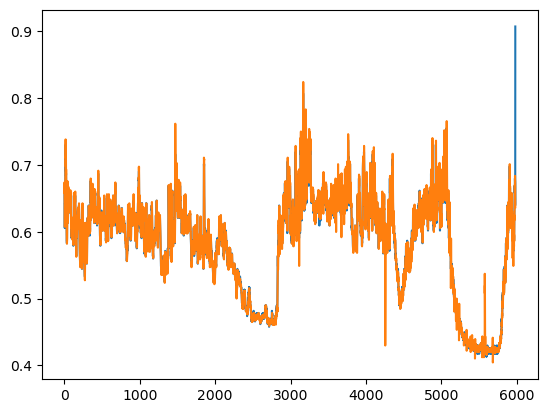

In [271]:
plt.plot(y_pred) #This is different from previous result when i fit the quadratic regression to resmapled data
    #But i accidentally used wrong input to resample the data
plt.plot(y)
plt.show()

In [272]:
residuals_RANSAC=y-y_pred

In [274]:
residuals

0      -0.013001
1       0.018055
2       0.012009
3       0.021554
4       0.011662
          ...   
5977    0.004678
5978    0.002674
5979    0.035447
5980    0.004242
5981   -0.299315
Name: SOT_ECG_3, Length: 5982, dtype: float64

In [273]:
residuals_RANSAC

0      -0.010615
1       0.019736
2       0.013076
3       0.021979
4       0.011770
          ...   
5977    0.007450
5978    0.005251
5979    0.036513
5980    0.005454
5981   -0.270563
Name: SOT_ECG_3, Length: 5982, dtype: float64

In [275]:
signal_0_2['Hexoskin_Reference'] #Reference Signal..aligned from previous context

0       0.671875
1       0.656250
2       0.640625
3       0.621094
4       0.609375
          ...   
5977    0.679688
5978    0.675781
5979    0.640625
5980    0.644531
5981    0.941406
Name: Hexoskin_Reference, Length: 5982, dtype: float64

In [276]:
signal_0_2['SOT_ECG_3'] #y for robust quadratic regression

0       0.658203
1       0.673828
2       0.652344
3       0.642578
4       0.621094
          ...   
5977    0.683594
5978    0.677734
5979    0.675781
5980    0.648438
5981    0.636719
Name: SOT_ECG_3, Length: 5982, dtype: float64

In [255]:
# Robust Linear Regression 
x = signal_0_2['Hexoskin_Reference']
y = signal_0_2['SOT_ECG_3']

In [256]:
# Fit quadratic model using RLM
quadratic = sm.RLM(y, np.column_stack((x, x**2)))
result = quadratic.fit()

In [257]:
# Predict values and calculate residuals
y_pred = result.predict(np.column_stack((x, x**2)))
residuals = y - y_pred #Difference in actual vs prediction

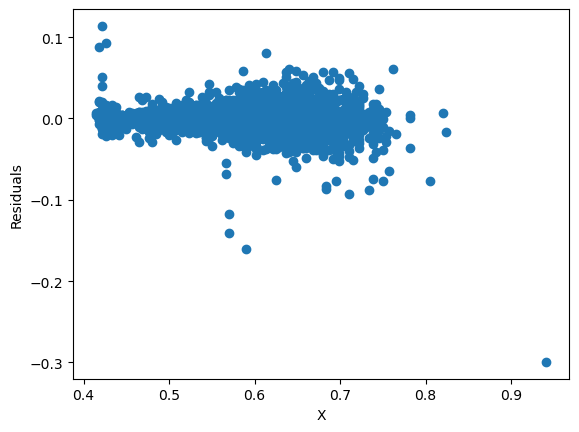

In [249]:
# Plot residuals
plt.plot(x, residuals, 'o')
plt.xlabel('X')
plt.ylabel('Residuals')
plt.show()

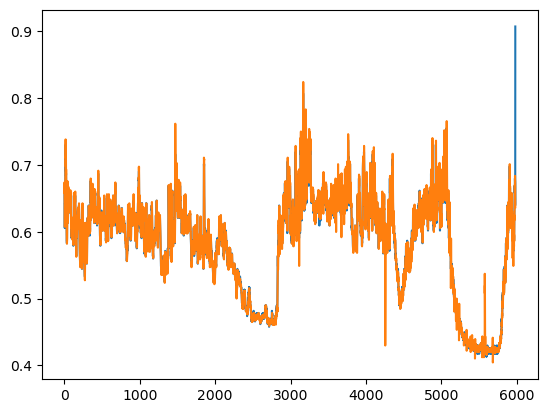

In [293]:
plt.plot(y_pred) #Accurate
plt.plot(y)

In [133]:
signal_0_2['residuals']=residuals

In [298]:
test_series=signal_0_2['SOT_ECG_3']+residuals_RANSAC

In [558]:
y=signal_0_2[1]

In [559]:
residuals = y - y_pred

In [ ]:
window_size=400 #This got me the weird answer
polyorder = 2
signal_0_2['smooth'] = signal.savgol_filter(signal_0_2['difference in beat to beat interval'], window_size, polyorder)

In [303]:
window_size=100 #Smoothing function to the predictions based 
polyorder = 2
signal_0_2['smooth'] = signal.savgol_filter(y_pred, window_size, polyorder)

In [305]:
R_R_intervals[0] #I got R_R intervals from ECG, how do i work backwards? Can I get an ECG from R_R intervals

array([0.609375  , 0.62109375, 0.640625  , ..., 0.640625  , 0.64453125,
       0.94140625])

In [304]:
signal_0_2

,Hexoskin_Reference,SOT_ECG_3,difference in beat to beat interval,residuals,smooth,residuals_ransac
0,0.671875,0.658203,0.013672,-0.013001,0.650345,-0.010615
1,0.656250,0.673828,-0.017578,0.018055,0.650408,0.019736
2,0.640625,0.652344,-0.011719,0.012009,0.650463,0.013076
3,0.621094,0.642578,-0.021484,0.021554,0.650509,0.021979
4,0.609375,0.621094,-0.011719,0.011662,0.650547,0.011770
...,...,...,...,...,...,...
5977,0.679688,0.683594,-0.003906,0.004678,0.644306,0.007450
5978,0.675781,0.677734,-0.001953,0.002674,0.645641,0.005251
5979,0.640625,0.675781,-0.035156,0.035447,0.647007,0.036513
5980,0.644531,0.648438,-0.003906,0.004242,0.648402,0.005454


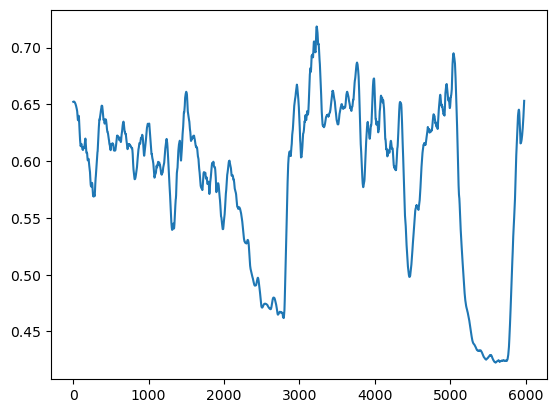

In [292]:
plt.plot(test) #savgol filter to y_pred

# Break in Code....Everything below was done previously with the cumulative sum until the next markdown cell

In [144]:
best_alignment_300_beats[0] #Hexoskin...reference
best_alignment_300_beats[1]#Nexus...missing data
best_alignment_300_beats[2]#SOT...aligned well
best_alignment_300_beats[3]#Faros...aligned pretty well

array([0.62890625, 0.625     , 0.62109375, 0.609375  , 0.6171875 ,
       0.60546875, 0.6015625 , 0.59765625, 0.59765625, 0.59765625,
       0.6015625 , 0.59765625, 0.59765625, 0.59765625, 0.60546875,
       0.6015625 , 0.609375  , 0.61328125, 0.62109375, 0.60546875,
       0.6015625 , 0.59765625, 0.59765625, 0.59375   , 0.58984375,
       0.578125  , 0.58203125, 0.5859375 , 0.59375   , 0.6015625 ,
       0.59375   , 0.59375   , 0.61328125, 0.61328125, 0.62109375,
       0.66015625, 0.6875    , 0.69921875, 0.703125  , 0.7109375 ,
       0.7109375 , 0.6796875 , 0.6484375 , 0.64453125, 0.640625  ,
       0.65625   , 0.66796875, 0.66796875, 0.6875    , 0.6953125 ,
       0.6875    , 0.71484375, 0.7265625 , 0.71484375, 0.69140625,
       0.69140625, 0.69140625, 0.68359375, 0.6875    , 0.671875  ,
       0.65234375, 0.6484375 , 0.640625  , 0.64453125, 0.65234375,
       0.671875  , 0.66796875, 0.6640625 , 0.63671875, 0.62109375,
       0.61328125, 0.60546875, 0.61328125, 0.64453125, 0.66015

In [150]:
reference_window=range(599,899)

In [312]:
#Linear correction for SOT...ECG_3...signal_0_2...I have no idea how this works because i used wrong values

x=best_alignment_300_beats[0][reference_window]
y=best_alignment_300_beats[2][576:876] #Time shift was 576 for 

x = sm.add_constant(x)

# Use the HuberT loss function, bisquare weighting function
model = sm.RLM(y, x, M=sm.robust.norms.LeastSquares())
results = model.fit()

slope=results.params[1]

In [267]:
results.params

array([0.02697665, 0.95841068])

In [268]:
signal_SOT_linear_corrected_fs=512*(1-slope)

In [269]:
signal_SOT_linear_corrected_fs #Totally incorrect value...

21.293730096947684

In [1047]:
desired_result.iloc[256]

SOT/EKG_filtered                           -0.160992
FAROS/ECG_filtered                         -0.157102
NEXUS/Sensor-B:EEG_filtered                 0.006942
HEXOSKIN/ECG_I_filtered                     0.253741
POLAR/RR_filtered                           0.000000
SOT/Akku                                 4049.808429
SOT/EKG 3                                 127.796991
SOT/aVL                                  -149.939910
SOT/EKG                                  -175.082506
SOT/EKG2                                  -48.688525
SOT/SpO2                                   98.023444
SOT/Pleth                                 464.980010
SOT/aVR                                   114.746522
SOT/EKG 1                                -174.982192
SOT/aVF                                    39.593481
SOT/Aktivitt                                0.000000
SOT/Krperlage                               1.000031
SOT/Puls                                  104.024909
SOT/EDF Annotations                         0.

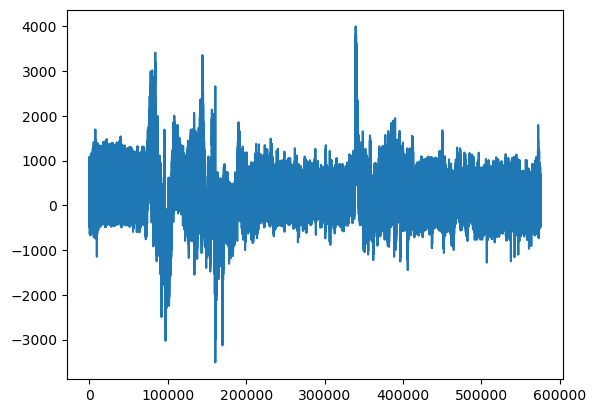

In [1068]:
plt.plot(reference_test)

In [1054]:
test=nk2.signal_resample(ECG_3['EKG 3'][:cut], desired_length=len(desired_result_sot), desired_sampling_rate=256)

In [1066]:
reference_test=desired_result['SOT/EKG 3']

In [1067]:
#Establish a reference window starting from the index in the middle of the reference signal
mid_point=len(reference_test)//2
reference_index=[mid_point-150, mid_point+150]
start=reference_index[0]
reference_window=range(start, start+300)

In [1069]:
#Find the minimum MAE for each possible window of across the sensors
maes=[]
window_length=300
for i in range(1, len(test)):
    try:
        window=test[i:i+window_length]
        difference=abs(reference_test[reference_window]-window)
        mae=np.mean(difference)
        maes.append(mae)
    except:
        pass
index=np.argmin(maes)

In [1070]:
index

411203

In [1071]:
reference_window

range(287402, 287702)

In [1072]:
#Establish Shift
shift=(reference_window[0]-index)
    
#Develop Dataframe from Data and shift data accordingly
df=pd.DataFrame(data=[reference_test, test]).T

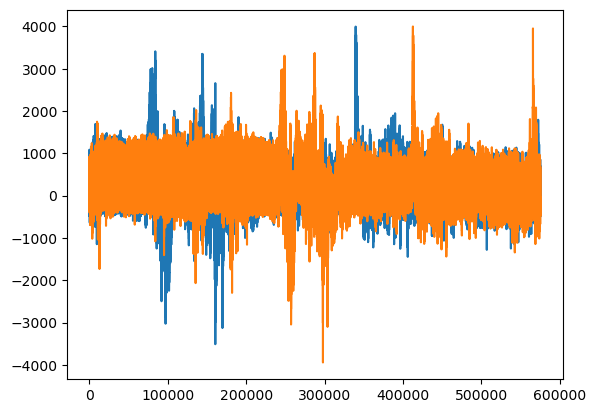

In [1074]:
plt.plot(df)

In [ ]:
#Establish Shift
shift=(reference_window[0]-index)
    
#Develop Dataframe from Data and shift data accordingly
df=pd.DataFrame(data=[desired_result_sot, test]).T
df[1]=df[1].shift(shift)
    
aligned_signals=df
    
    
#plot shifted data and OG data to see comparison
fig,ax=plt.subplots(1,2)
ax[0].plot(reference_sensor)
ax[0].plot(sensor_2)
ax[1].plot(df)
plt.show()
    
return aligned_signals

In [1048]:
edf_SOT_df

,time,Akku,EKG 3,aVL,EKG,EKG2,SpO2,Pleth,aVR,EKG 1,aVF,Aktivitt,Krperlage,Puls
0,0.000000,0.0,1.465201,-2694.505495,-5390.476190,-5390.476190,0.000000e+00,8.526513e-08,5393.406593,-5390.476190,-2694.505495,3.552714e-09,5000000.0,0.000000e+00
1,0.001953,0.0,1.465201,-2228.571429,-4461.538462,-4461.538462,-5.452437e+05,-6.366244e+07,4461.538462,-4461.538462,-2228.571429,-6.124206e+05,5000000.0,-5.341162e+05
2,0.003906,0.0,1.465201,-2043.956044,-4092.307692,-4092.307692,-1.081186e+06,2.842171e-08,4092.307692,-4092.307692,-2043.956044,-1.178185e+06,5000000.0,-1.059121e+06
3,0.005859,0.0,1.465201,-2064.468864,-4130.402930,-4130.402930,-1.607753e+06,3.507555e+07,4133.333333,-4130.402930,-2064.468864,-1.696048e+06,5000000.0,-1.574942e+06
4,0.007812,0.0,1.465201,-2064.468864,-4130.402930,-4130.402930,-2.124877e+06,-5.684342e-08,4133.333333,-4130.402930,-2064.468864,-2.165084e+06,5000000.0,-2.081512e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872891,3657.990234,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00
1872892,3657.992188,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00
1872893,3657.994141,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00
1872894,3657.996094,0.0,1.465201,-2996.336996,-5997.069597,-5997.069597,0.000000e+00,0.000000e+00,5997.069597,-5997.069597,-2996.336996,0.000000e+00,5000000.0,0.000000e+00


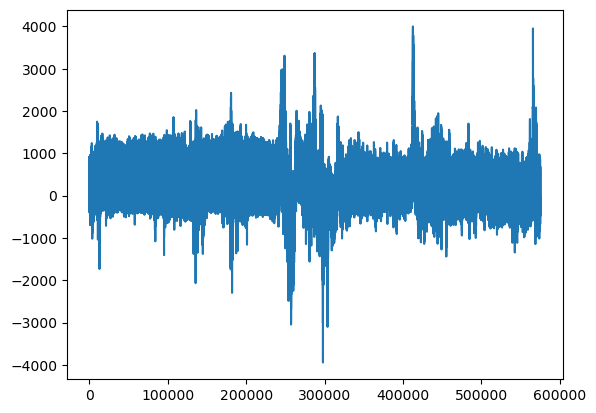

In [1055]:
plt.plot(test)

In [183]:
pd.Series(ecg_3_resampled_3)

0        -0.094499
1        -0.341023
2        -0.574240
3        -0.776651
4        -0.934923
            ...   
896507    0.000010
896508    0.000010
896509    0.000010
896510    0.000010
896511    0.000000
Length: 896512, dtype: float64

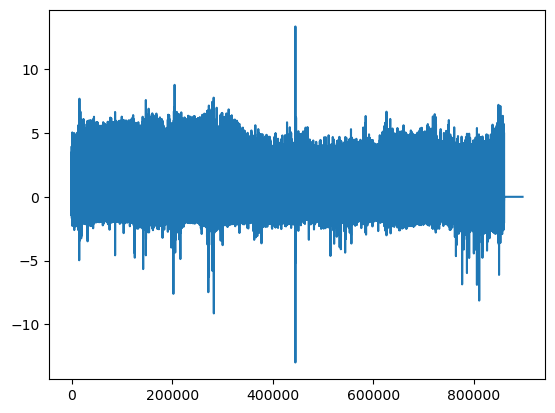

In [184]:
plt.plot(ecg_3_resampled_3)
plt.show()

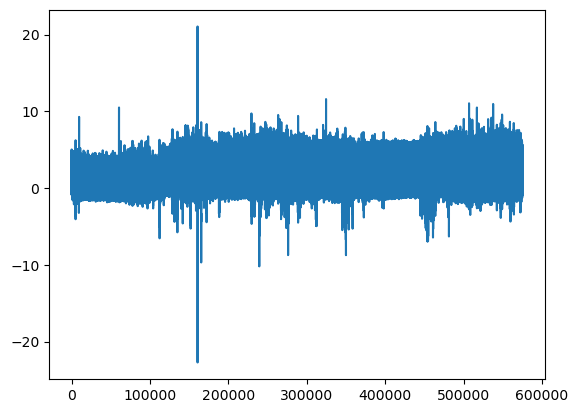

In [219]:
plt.plot(desired_result['SOT/EKG_filtered'])

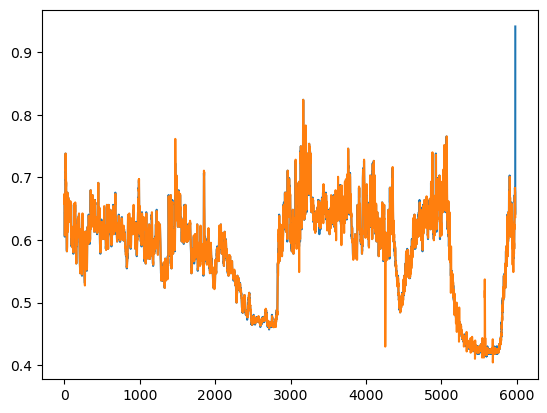

In [225]:
plt.plot(signal_0_2['Hexoskin_Reference'])
plt.plot(signal_0_2['SOT_ECG_3'])
#Y Values is R_R intervals (time in ms), X axis is index
plt.show()

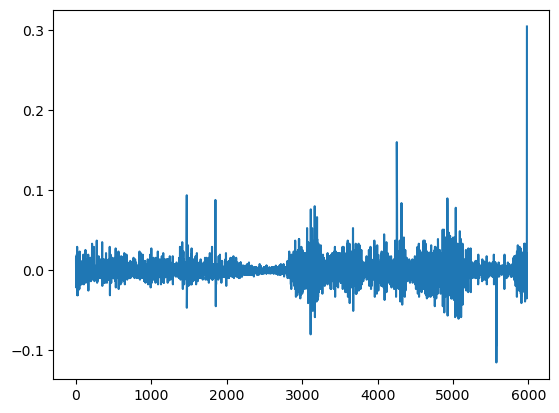

In [227]:
plt.plot(signal_0_2['difference in beat to beat interval']) #Y values are cumulative difference in R_R intervals..

In [674]:
window_size=300
polyorder = 2
signal_0_2_resampled['residuals_smooth'] = signal.savgol_filter(signal_0_2_resampled['continuous difference'], 
                                                                window_size, polyorder)


/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_37810/1945387243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_0_2_resampled['residuals_smooth'] = signal.savgol_filter(signal_0_2_resampled['continuous difference'],


In [707]:
signal_0_2_resampled #Old df...residuals smooth was calculated from ransac regressor of continous difference

,0,1,difference,continuous difference,residuals_smooth
0,0.609375,0.657789,-0.048414,0.000000,0.360602
1,0.621094,0.674538,-0.053444,0.048414,0.357055
2,0.640625,0.653221,-0.012596,0.101858,0.353502
3,0.644531,0.642562,0.001969,0.114454,0.349942
4,0.652344,0.621245,0.031099,0.112485,0.346375
...,...,...,...,...,...
5994,0.679688,0.622768,0.056920,0.994749,1.292155
5995,0.675781,0.627336,0.048446,0.937829,1.304649
5996,0.640625,0.624290,0.016335,0.889383,1.317116
5997,0.644531,0.616677,0.027854,0.873049,1.329557


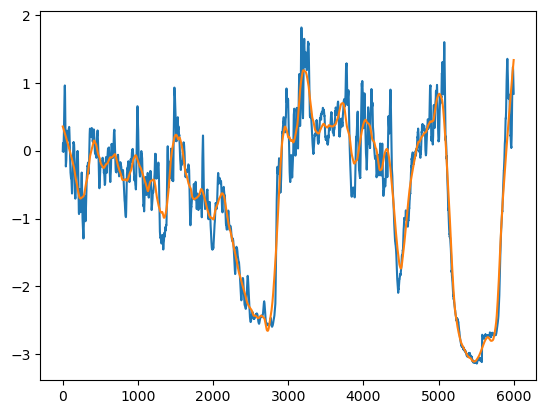

In [675]:
#The smooth curve of beat-to-beat-differences was interpolated to get a sample-based corrective value to 
    #adjust for the local frequency

plt.plot(signal_0_2_resampled['continuous difference'])
plt.plot(signal_0_2_resampled['residuals_smooth']) #Much smoother line, great.
plt.show()

In [871]:
#For manually screening the sample rates

Hz=[]
for x in range(len(ecg_3)-1):
    y=1/((time_3[x+1]-time_3[x]))
    Hz.append(y)

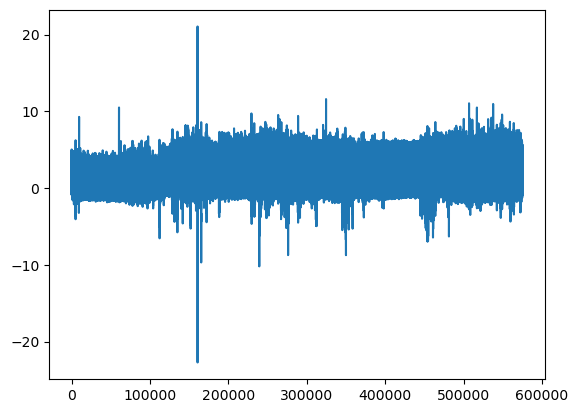

In [29]:
plt.plot(desired_result.iloc[:,0])

# Following Marcus Vollmers Presentation He Sent Me

d=time delay...i.e. shift needed to align the r_r peaks

s=the actual time delay...difference between the r_r intervals

You want a value of d that makes the sum of s very close to zero. I did that with my function

Pairwise differences show that the value of s slowly increaseing/decreasing over time due to device mistakes in local sampling frequency
        #But when I plot the differences, s(i), i dont get anything close to that...lets see

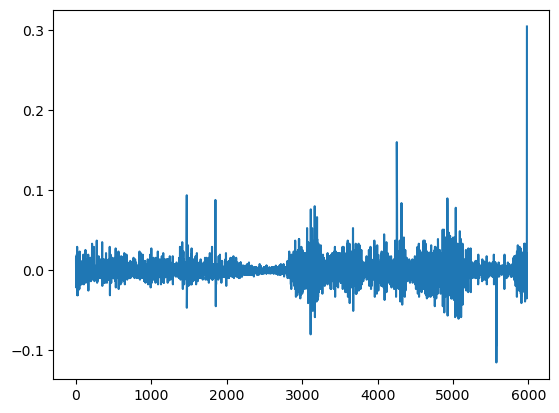

In [311]:
plt.plot(signal_0_2['difference in beat to beat interval'])

In [318]:
signal_0_2 #Get the difference of each individual sensor

,Hexoskin_Reference,SOT_ECG_3,difference in beat to beat interval,smooth,residuals_ransac,residuals_Linear_Regression_with_quadratic
0,0.671875,0.658203,0.013672,0.650345,-0.010615,-0.013001
1,0.656250,0.673828,-0.017578,0.650408,0.019736,0.018055
2,0.640625,0.652344,-0.011719,0.650463,0.013076,0.012009
3,0.621094,0.642578,-0.021484,0.650509,0.021979,0.021554
4,0.609375,0.621094,-0.011719,0.650547,0.011770,0.011662
...,...,...,...,...,...,...
5977,0.679688,0.683594,-0.003906,0.644306,0.007450,0.004678
5978,0.675781,0.677734,-0.001953,0.645641,0.005251,0.002674
5979,0.640625,0.675781,-0.035156,0.647007,0.036513,0.035447
5980,0.644531,0.648438,-0.003906,0.648402,0.005454,0.004242


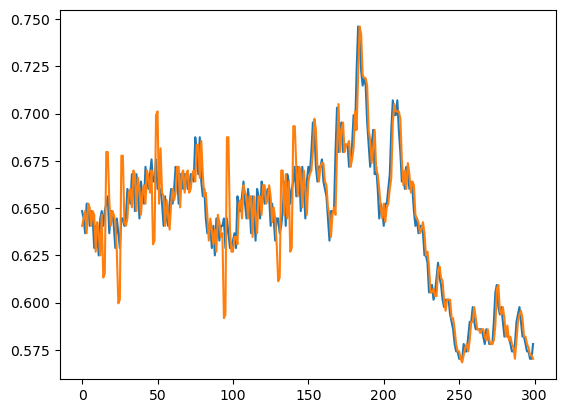

In [467]:
plt.plot(best_alignment_300_beats[0][reference_window])
plt.plot(best_alignment_300_beats[2][576:876])

In [565]:
results.params

array([-1.23548061e-03,  3.04821045e-07])

In [584]:
line=slope*x[:,1]+intercept

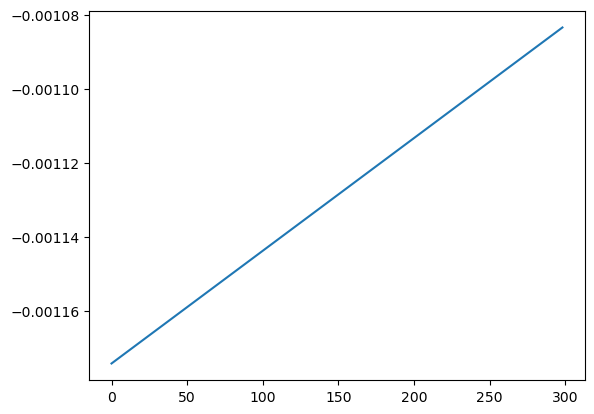

In [585]:
plt.plot(line)

In [488]:
pd.Series(best_alignment_300_beats[0][reference_window]).diff()

0           NaN
1     -0.003906
2     -0.007812
3      0.015625
4      0.000000
         ...   
295   -0.003906
296    0.000000
297   -0.003906
298    0.000000
299    0.007812
Length: 300, dtype: float64

In [489]:
pd.Series(best_alignment_300_beats[2][576:876]).diff()

0           NaN
1      0.003906
2      0.003906
3     -0.011719
4      0.015625
         ...   
295   -0.003906
296   -0.001953
297   -0.003906
298    0.000000
299   -0.001953
Length: 300, dtype: float64

In [578]:
signal_0_2['continuous_diff_HEX']=signal_0_2['Hexoskin_Reference'].diff()
signal_0_2['continuous_diff_SOT']=signal_0_2['SOT_ECG_3'].diff()

In [579]:
diff_reference=pd.Series(best_alignment_300_beats[0][reference_window]).diff().dropna().to_numpy()
diff_SOT=pd.Series(best_alignment_300_beats[2][576:876]).diff().dropna().to_numpy()

x=np.array(range(201,500))
y=diff_SOT #Time shift was 576 for 

x = sm.add_constant(x)

# Use the HuberT loss function, bisquare weighting function
model = sm.RLM(y,x, M=sm.robust.norms.HuberT())
results = model.fit()

slope=results.params[1]
intercept=results.params[0]

In [580]:
results.params

array([-1.23548061e-03,  3.04821045e-07])

In [581]:
fs=512
adjustment_factor=fs*(1-slope)

In [582]:
adjustment_factor

511.99984393162504

# Computing Continuous Beat to Beat Differences...Figure 4

In [586]:
signal_0_2

,Hexoskin_Reference,SOT_ECG_3,difference in beat to beat interval,smooth,residuals_ransac,residuals_Linear_Regression_with_quadratic,continuous_diff_HEX,continuous_diff_SOT
0,0.671875,0.658203,0.013672,0.650345,-0.010615,-0.013001,NaN,NaN
1,0.656250,0.673828,-0.017578,0.650408,0.019736,0.018055,-0.015625,0.015625
2,0.640625,0.652344,-0.011719,0.650463,0.013076,0.012009,-0.015625,-0.021484
3,0.621094,0.642578,-0.021484,0.650509,0.021979,0.021554,-0.019531,-0.009766
4,0.609375,0.621094,-0.011719,0.650547,0.011770,0.011662,-0.011719,-0.021484
...,...,...,...,...,...,...,...,...
5977,0.679688,0.683594,-0.003906,0.644306,0.007450,0.004678,-0.003906,0.021484
5978,0.675781,0.677734,-0.001953,0.645641,0.005251,0.002674,-0.003906,-0.005859
5979,0.640625,0.675781,-0.035156,0.647007,0.036513,0.035447,-0.035156,-0.001953
5980,0.644531,0.648438,-0.003906,0.648402,0.005454,0.004242,0.003906,-0.027344


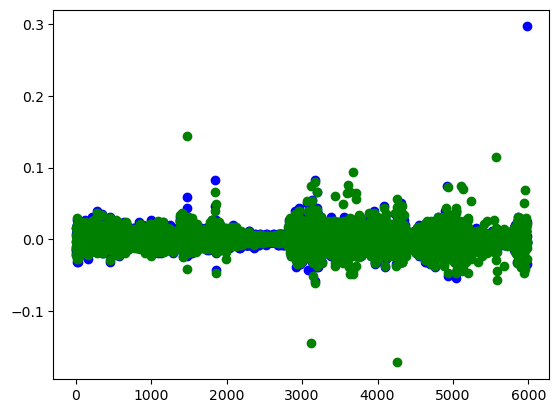

In [587]:
plt.scatter(x=signal_0_2.index, y=signal_0_2['continuous_diff_HEX'], color='blue')
plt.scatter(x=signal_0_2.index, y=signal_0_2['continuous_diff_SOT'], color='green')

# Now applying linear quadratic Regression to the above points

In [589]:
#drop NaN values from dataframe

continuous_differences=pd.DataFrame([signal_0_2['continuous_diff_HEX'], signal_0_2['continuous_diff_SOT']])
continuous_differences=continuous_differences.T.dropna()

In [592]:
continuous_differences

,continuous_diff_HEX,continuous_diff_SOT
1,-0.015625,0.015625
2,-0.015625,-0.021484
3,-0.019531,-0.009766
4,-0.011719,-0.021484
5,-0.003906,-0.011719
...,...,...
5977,-0.003906,0.021484
5978,-0.003906,-0.005859
5979,-0.035156,-0.001953
5980,0.003906,-0.027344


In [861]:
#Robust Quadratic Regression to identify local changes in sampling frequency...this one doesn't work all of a sudden

#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(continuous_differences['continuous_diff_HEX'].to_numpy().reshape(-1,1)) #Fit to reference signal


y=continuous_differences['continuous_diff_SOT']


#Fit a RANSAC Regressor to the Data
ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)

#Use Ransac Regressor to Make predictions on data
y_pred = ransac.predict(X_poly)

In [596]:
new_residuals=y_pred-y

In [1080]:
pd.Series(y_pred) #units=ms

0      -0.008931
1      -0.008931
2      -0.010781
3      -0.007073
4      -0.003332
          ...   
5976   -0.003332
5977   -0.003332
5978   -0.018096
5979    0.000442
5980    0.166100
Length: 5981, dtype: float64

In [1081]:
from scipy.interpolate import interp1d

In [ ]:
x = np.array([0, 1, 2, 3])
y = np.array([0, 1, 4, 9])

f = interp1d(x, y, kind='linear')

x_new = np.array([0.5, 1.5, 2.5])
y_new = f(x_new)


In [854]:
inlier_reg = ransac.estimator_
intercept = inlier_reg.intercept_
coefficients = inlier_reg.coef_

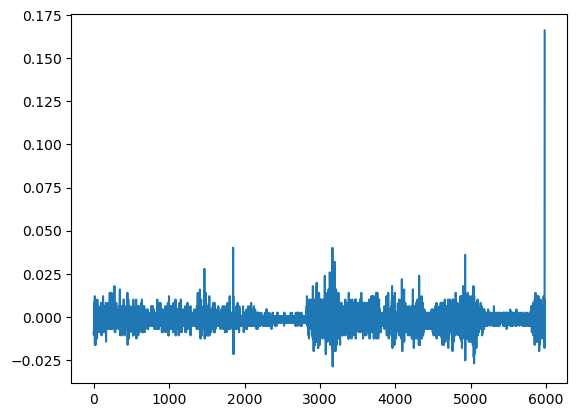

In [862]:
plt.plot(y_pred)

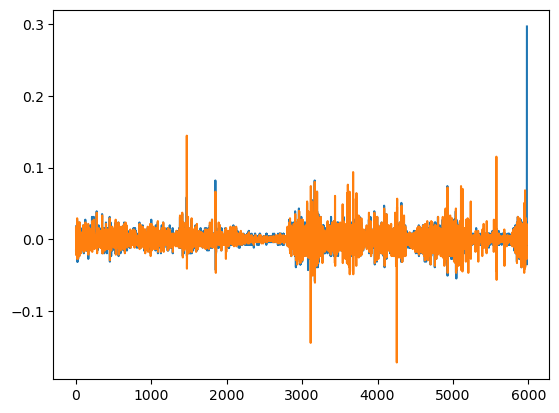

In [611]:
plt.plot(continuous_differences['continuous_diff_HEX'])
plt.plot(continuous_differences['continuous_diff_SOT'])

# Very similar to Figure 4 in the Paper for SOT

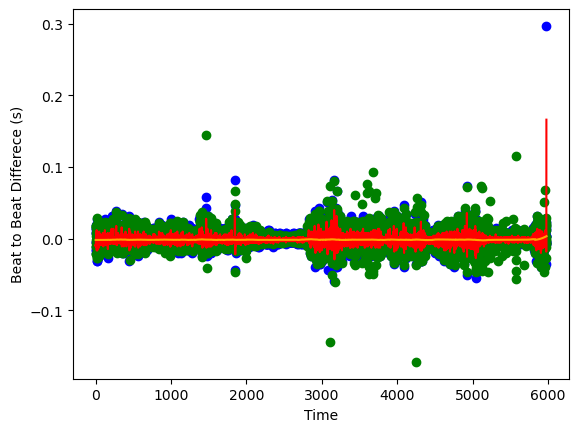

In [915]:
#plot data
plt.scatter(x=signal_0_2.index, y=signal_0_2['continuous_diff_HEX'], color='blue')
plt.scatter(x=signal_0_2.index, y=signal_0_2['continuous_diff_SOT'], color='green')
plt.xlabel('Time')
plt.ylabel('Beat to Beat Differece (s)')
plt.plot(y_pred, color='red')
plt.plot(continuous_differences['SOT_smooth'], color='orange') #Smooth line appears to get rid of outliers

In [627]:
continuous_differences['continuous_diff_SOT'].rolling(300).median().unique() #Need to find way to get rid of outliers

array([        nan, -0.00195312, -0.00097656,  0.        ,  0.00097656,
        0.00195312])

# Smooth Out the Curve with the Savgol Filter...interpolation=create smooth curve that passes through data points
    
    #The curve will tell you by how many milliseconds the beat to beat difference changes for each period of time throughout the experiment
    
    #Local Frequency==red line (i.e local freqeuncy is the sample_rate+the beat to beat difference)
    
    #Values for each segment were used to correct the ECG time series (How??)
    
    #Values were also used as input coordinates to resample data to desired 256. 

In [616]:
window_size=300
polyorder = 2
continuous_differences['SOT_smooth'] = signal.savgol_filter(continuous_differences['continuous_diff_SOT'], 
                                                                window_size, polyorder)

In [628]:
continuous_differences #Sot Smooth is used to correct the ECG signals

,continuous_diff_HEX,continuous_diff_SOT,SOT_smooth
1,-0.015625,0.015625,-0.000440
2,-0.015625,-0.021484,-0.000437
3,-0.019531,-0.009766,-0.000434
4,-0.011719,-0.021484,-0.000431
5,-0.003906,-0.011719,-0.000429
...,...,...,...
5977,-0.003906,0.021484,-0.000403
5978,-0.003906,-0.005859,-0.000430
5979,-0.035156,-0.001953,-0.000457
5980,0.003906,-0.027344,-0.000485


How do i know where to apply the correction values from SOT_smooth?

    Looks like when len ECG_3/len SOT_smooth is it close to 300. 313 to be exact but because I got rid of some extra values to make the dataframes line up it makes sense teh OG ECG would have more values.

In [665]:
test=time_3.iloc[:300]

In [729]:
short_df=continuous_differences['SOT_smooth'][:5]

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/770913360.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  short_df=continuous_differences['SOT_smooth'][:5]


In [769]:
test=time_3[:300*5]

In [771]:
long_df=test

In [768]:
short_df

1   -0.000440
2   -0.000437
3   -0.000434
4   -0.000431
5   -0.000429
Name: SOT_smooth, dtype: float64

In [788]:
for i in range(5):
    test.iloc[i*300:(i+1)*300] -= short_df.iloc[i]

In [789]:
test #This works

0       0.001320
1       0.003274
2       0.005227
3       0.007180
4       0.009133
          ...   
1495    2.920779
1496    2.922732
1497    2.924685
1498    2.926638
1499    2.928592
Name: time, Length: 1500, dtype: float64

In [790]:
correction_values=continuous_differences['SOT_smooth']
time_3=ECG_3['time'] 

In [791]:
len(time_3)//len(correction_values)

313

#Lets drop the data of the end to make it an even 300

In [794]:
cut=len(correction_values)*300
time_3=time_3[:cut]

In [795]:
len(time_3) 

0             0.000000
1             0.001953
2             0.003906
3             0.005859
4             0.007812
              ...     
1794295    3504.482422
1794296    3504.484375
1794297    3504.486328
1794298    3504.488281
1794299    3504.490234
Name: time, Length: 1794300, dtype: float64

# When I cut the ECG_3 data to fit be corrected by the Smooth line by the 300 average we established the length matches that of the reference signal!!

In [797]:
len(time_3)//len(correction_values)

300

In [827]:
for i in range(0, len(correction_values)):
    time_OG.iloc[i*300:(i+1)*300] += correction_values.iloc[i]

In [814]:
correction_values

1      -0.000440
2      -0.000437
3      -0.000434
4      -0.000431
5      -0.000429
          ...   
5977   -0.000403
5978   -0.000430
5979   -0.000457
5980   -0.000485
5981   -0.000512
Name: SOT_smooth, Length: 5981, dtype: float64

In [812]:
time_3 #adjusted with -=

0             0.000440
1             0.002393
2             0.004346
3             0.006300
4             0.008253
              ...     
1794295    3504.482934
1794296    3504.484887
1794297    3504.486840
1794298    3504.488793
1794299    3504.490746
Name: time, Length: 1794300, dtype: float64

In [813]:
time_test #adjusted with +=

0            -0.000440
1             0.001513
2             0.003466
3             0.005419
4             0.007372
              ...     
1794295    3504.481910
1794296    3504.483863
1794297    3504.485816
1794298    3504.487769
1794299    3504.489722
Name: time, Length: 1794300, dtype: float64

In [828]:
time_OG

0            -0.000440
1             0.001513
2             0.003466
3             0.005419
4             0.007372
              ...     
1794295    3504.481910
1794296    3504.483863
1794297    3504.485816
1794298    3504.487769
1794299    3504.489722
Name: time, Length: 1794300, dtype: float64

In [825]:
time_OG=ECG_3['time'][:cut]

In [830]:
ECG_3['time'][0]=0

In [834]:
adjusted_SOT=ECG_3[:cut]

In [833]:
ECG_1

,time,4113:ECG_I
0,0.000000,1900.842412
1,0.003906,-8697.550007
2,0.007812,-8703.950002
3,0.011719,-8703.950002
4,0.015625,-8703.950002
...,...,...
896507,3501.980469,-8703.950002
896508,3501.984375,-8703.950002
896509,3501.988281,-8703.950002
896510,3501.992188,-8703.950002


In [835]:
adjusted_SOT['EKG 3']

,time,Akku,EKG 3
0,0.000000,0.000000e+00,1.465201
1,0.001513,0.000000e+00,1.465201
2,0.003466,0.000000e+00,1.465201
3,0.005419,0.000000e+00,1.465201
4,0.007372,0.000000e+00,1.465201
...,...,...,...
1794295,3504.481910,4.049817e+06,-19.047619
1794296,3504.483863,4.049817e+06,-51.282051
1794297,3504.485816,4.049817e+06,-68.864469
1794298,3504.487769,4.049817e+06,-48.351648


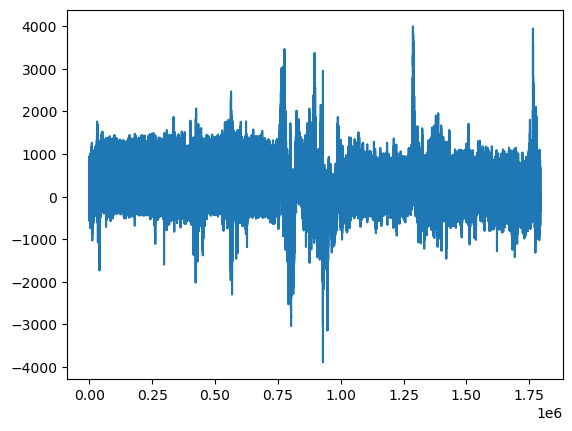

In [838]:
plt.plot(adjusted_SOT['EKG 3'])

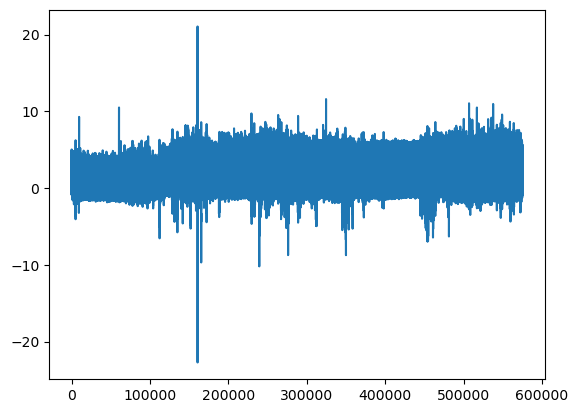

In [837]:
plt.plot(desired_result['SOT/EKG_filtered'])

In [845]:
test=signal.resample(adjusted_SOT['EKG 3'], num=len(desired_result), domain='time')

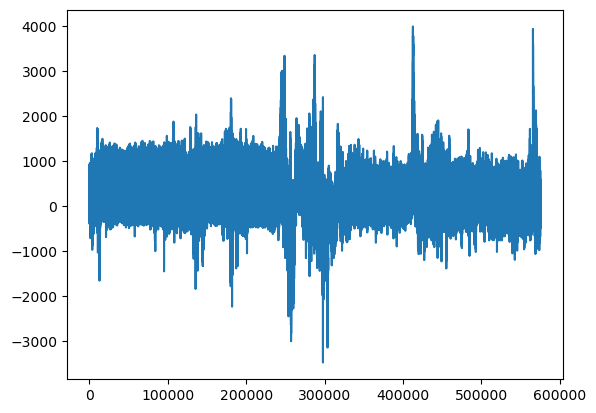

In [846]:
plt.plot(test)

In [848]:
continuous_differences

,continuous_diff_HEX,continuous_diff_SOT,SOT_smooth
1,-0.015625,0.015625,-0.000440
2,-0.015625,-0.021484,-0.000437
3,-0.019531,-0.009766,-0.000434
4,-0.011719,-0.021484,-0.000431
5,-0.003906,-0.011719,-0.000429
...,...,...,...
5977,-0.003906,0.021484,-0.000403
5978,-0.003906,-0.005859,-0.000430
5979,-0.035156,-0.001953,-0.000457
5980,0.003906,-0.027344,-0.000485


In [847]:
signal_0_2

,Hexoskin_Reference,SOT_ECG_3,difference in beat to beat interval,smooth,residuals_ransac,residuals_Linear_Regression_with_quadratic,continuous_diff_HEX,continuous_diff_SOT
0,0.671875,0.658203,0.013672,0.650345,-0.010615,-0.013001,NaN,NaN
1,0.656250,0.673828,-0.017578,0.650408,0.019736,0.018055,-0.015625,0.015625
2,0.640625,0.652344,-0.011719,0.650463,0.013076,0.012009,-0.015625,-0.021484
3,0.621094,0.642578,-0.021484,0.650509,0.021979,0.021554,-0.019531,-0.009766
4,0.609375,0.621094,-0.011719,0.650547,0.011770,0.011662,-0.011719,-0.021484
...,...,...,...,...,...,...,...,...
5977,0.679688,0.683594,-0.003906,0.644306,0.007450,0.004678,-0.003906,0.021484
5978,0.675781,0.677734,-0.001953,0.645641,0.005251,0.002674,-0.003906,-0.005859
5979,0.640625,0.675781,-0.035156,0.647007,0.036513,0.035447,-0.035156,-0.001953
5980,0.644531,0.648438,-0.003906,0.648402,0.005454,0.004242,0.003906,-0.027344


# Doing Smoothing of y_pred which is the fitted "beat misplacements" as opposed to smoothing of just the differences

In [870]:
continuous_differences

,continuous_diff_HEX,continuous_diff_SOT,SOT_smooth
1,-0.015625,0.015625,-0.001719
2,-0.015625,-0.021484,-0.001718
3,-0.019531,-0.009766,-0.001716
4,-0.011719,-0.021484,-0.001715
5,-0.003906,-0.011719,-0.001713
...,...,...,...
5977,-0.003906,0.021484,0.003298
5978,-0.003906,-0.005859,0.003354
5979,-0.035156,-0.001953,0.003410
5980,0.003906,-0.027344,0.003467


In [868]:
continuous_differences['SOT_smooth'] = signal.savgol_filter(y_pred, window_size, polyorder)

In [873]:
len(continuous_differences)

5981

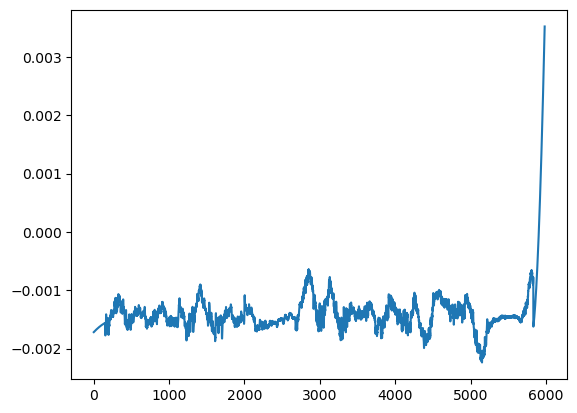

In [871]:
plt.plot(continuous_differences['SOT_smooth'])

In [877]:
test=signal_0_2['SOT_ECG_3']-continuous_differences['SOT_smooth']

In [879]:
test[0]=signal_0_2['SOT_ECG_3'][0]

Test below is the corrected R_R intervals

In [899]:
test 

0       0.658203
1       0.675547
2       0.654061
3       0.644294
4       0.622809
          ...   
5977    0.680295
5978    0.674380
5979    0.672371
5980    0.644970
5981    0.633195
Length: 5982, dtype: float64

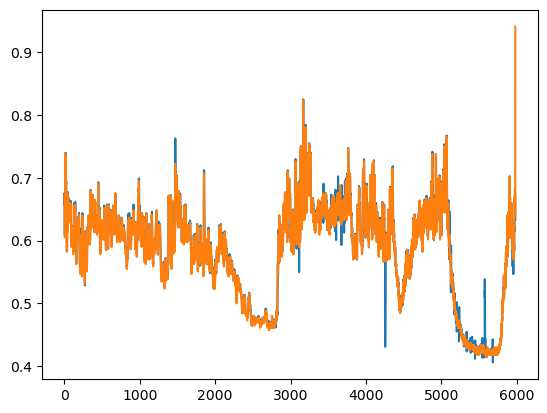

In [882]:
plt.plot(test)
plt.plot(signal_0_2['Hexoskin_Reference'])

In [909]:
continuous_differences

,continuous_diff_HEX,continuous_diff_SOT,SOT_smooth
1,-0.015625,0.015625,-0.001719
2,-0.015625,-0.021484,-0.001718
3,-0.019531,-0.009766,-0.001716
4,-0.011719,-0.021484,-0.001715
5,-0.003906,-0.011719,-0.001713
...,...,...,...
5977,-0.003906,0.021484,0.003298
5978,-0.003906,-0.005859,0.003354
5979,-0.035156,-0.001953,0.003410
5980,0.003906,-0.027344,0.003467


In [893]:
ECG_3['unitless']=ecg_3

In [894]:
ECG_3

,time,Akku,EKG 3,unitless
0,0.000000,0.0,1.465201,-0.094499
1,0.001513,0.0,1.465201,-0.213625
2,0.003466,0.0,1.465201,-0.331315
3,0.005419,0.0,1.465201,-0.445836
4,0.007372,0.0,1.465201,-0.555438
...,...,...,...,...
1872891,3657.990234,0.0,1.465201,0.000010
1872892,3657.992188,0.0,1.465201,0.000010
1872893,3657.994141,0.0,1.465201,0.000010
1872894,3657.996094,0.0,1.465201,0.000010


In [897]:
for i in range(0, len(correction_values)):
    ECG_3['unitless'].iloc[i*300:(i+1)*300] += correction_values.iloc[i]

In [895]:
result=correction_values

1      -0.000440
2      -0.000437
3      -0.000434
4      -0.000431
5      -0.000429
          ...   
5977   -0.000403
5978   -0.000430
5979   -0.000457
5980   -0.000485
5981   -0.000512
Name: SOT_smooth, Length: 5981, dtype: float64

In [934]:
#Linearly interpolated the interbeat segments through SOT_smooth...SOT_smooth is the smoothed y_pred line which
    #was the product of the robust quadratic regression which was fitted from X(reference) and y(sensor to be adjusted)
    

sample_based_corrective_value=nk2.signal_resample(continuous_differences['SOT_smooth'], desired_length=len(ECG_3))

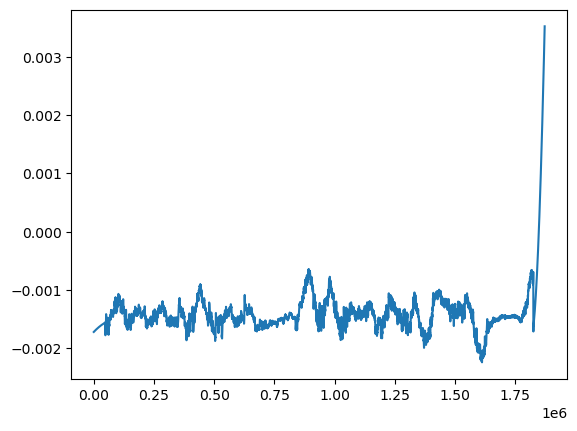

In [935]:
#This gives mw what I believe to be the change in sampling rate over the course of the data. Obviously it doesn't 
    #change much


plt.plot(sample_based_corrective_value)

In [919]:
ECG_3

,time,Akku,EKG 3,unitless
0,0.000000,0.0,1.465201,-0.094939
1,0.001513,0.0,1.465201,-0.214065
2,0.003466,0.0,1.465201,-0.331755
3,0.005419,0.0,1.465201,-0.446276
4,0.007372,0.0,1.465201,-0.555878
...,...,...,...,...
1872891,3657.990234,0.0,1.465201,0.000010
1872892,3657.992188,0.0,1.465201,0.000010
1872893,3657.994141,0.0,1.465201,0.000010
1872894,3657.996094,0.0,1.465201,0.000010


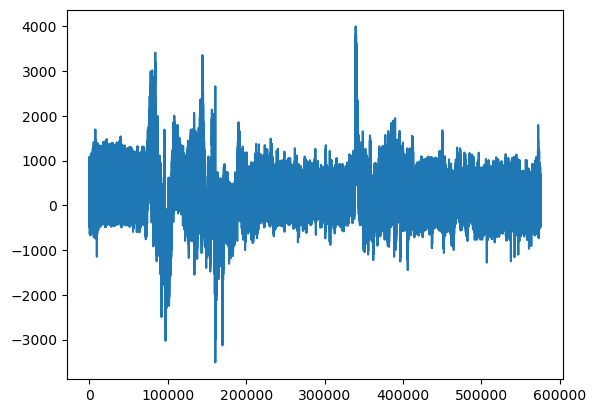

In [1084]:
desired_result_sot=desired_result['SOT/EKG 3']
plt.plot(desired_result_sot)

"these values were used to correct the x-values of the ECG time series and served as input coordinates 
  to linearly resample all signals of a device to the reference frequency of 256 Hz"
  
  
These values corrected the x-axis of the ECG time series could mean they change the amount of samples per second, which is in fact the sampling rate..

    Then "serving as input coordinates" could mean they were the index (len), or input coordinates to resample the data once we know how long it is supposed to be?

In [936]:
sample_based_corrective_value=pd.Series(sample_based_corrective_value)

In [937]:
sample_rate_SOT=sample_based_corrective_value+512

In [940]:
sample_rate_SOT.mean()

511.9986122696805

In [939]:
sample_rate_SOT

0          511.998281
1          511.998281
2          511.998281
3          511.998281
4          511.998281
              ...    
1872891    512.003524
1872892    512.003524
1872893    512.003524
1872894    512.003524
1872895    512.003524
Length: 1872896, dtype: float64

In [1086]:
test=ECG_3['unitless'][:cut]

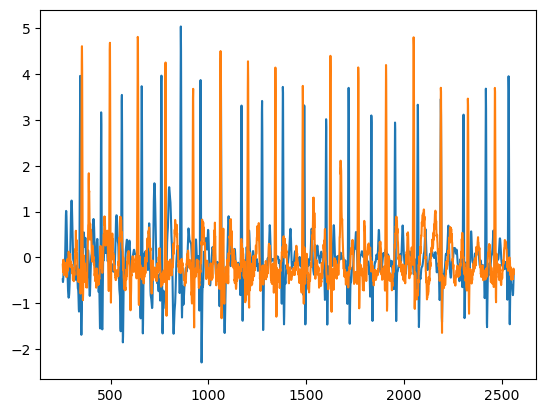

In [960]:
plt.plot(pd.Series(result).iloc[256:2560])
plt.plot(desired_result_sot.iloc[256:2560])

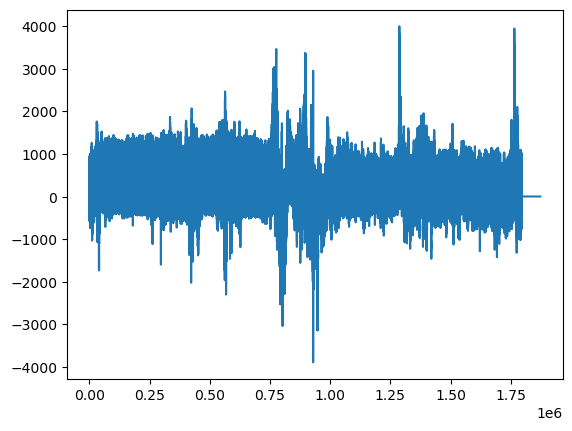

In [1090]:
plt.plot(ECG_3['EKG 3'])

# Marcus Answer. Adjusting X_time values

In [1092]:
x=ECG_1['4113:ECG_I']

In [1094]:
y=ECG_3['EKG 3']

In [1102]:
signals, infor=nk2.ecg_process(y, sampling_rate=512)

In [1104]:
signals['time']=ECG_3['time']

In [1105]:
signals=signals.drop(columns=signals.iloc[:,5:19])

In [1120]:
adjustment_df=signals[signals['ECG_R_Peaks']==1] #From this we could 

In [1123]:
adjustment_df=adjustment_df[adjustment_df['time']<3502]

In [1125]:
adjustment_df['adjusment']=continuous_differences['SOT_smooth']

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/1759951510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjustment_df['adjusment']=continuous_differences['SOT_smooth']


In [1127]:
adjustment_df['adjusted_time']=adjustment_df['time']+adjustment_df['adjusment']

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_50383/1003649690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjustment_df['adjusted_time']=adjustment_df['time']+adjustment_df['adjusment']


In [1144]:
adjustemnts=continuous_differences['SOT_smooth']

In [1147]:
adjustment_df=adjustment_df.drop(columns=adjustment_df.iloc[:,-2:]).reset_index(drop=True)

In [1149]:
adjustment_df['adjustments']=adjustemnts

In [1151]:
adjustemnts

1      -0.001719
2      -0.001718
3      -0.001716
4      -0.001715
5      -0.001713
          ...   
5977    0.003298
5978    0.003354
5979    0.003410
5980    0.003467
5981    0.003524
Name: SOT_smooth, Length: 5981, dtype: float64

In [1152]:
adjustment_df['adjusted_time'] = np.where(np.isnan(adjustment_df['adjustments']),
                                           adjustment_df['time'],
                                           adjustment_df['time'] + adjustment_df['adjustments'])


In [1155]:
x=adjustment_df['adjusted_time']

In [1200]:
continuous_differences['SOT_smooth']

1      -0.001719
2      -0.001718
3      -0.001716
4      -0.001715
5      -0.001713
          ...   
5977    0.003298
5978    0.003354
5979    0.003410
5980    0.003467
5981    0.003524
Name: SOT_smooth, Length: 5981, dtype: float64

In [1198]:
ref_Ann_test=signal_0_2['Hexoskin_Reference']

In [1202]:
ref_Ann_test

0       0.671875
1       0.656250
2       0.640625
3       0.621094
4       0.609375
          ...   
5976    0.683594
5977    0.679688
5978    0.675781
5979    0.640625
5980    0.644531
Name: Hexoskin_Reference, Length: 5981, dtype: float64

In [1165]:
from scipy.interpolate import interp1d

In [1216]:
ECG_t=signals['ECG_Raw']

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


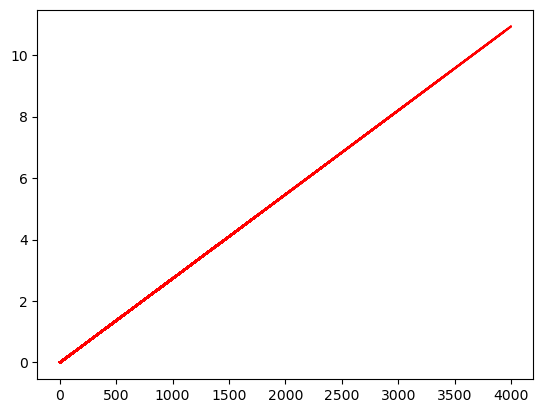

In [1217]:
ref_Ann = ref_Ann_test #R_peaks for reference annotations
dff = continuous_differences['SOT_smooth'] #Delay of the second signal (SOT Smooth)


f = interp1d(ref_Ann, dff, kind='linear', fill_value='extrapolate')
vq = f(ECG_t)
plt.plot(ECG_t, vq, 'r')


In [1313]:
ECG_t=signals['time']

In [1314]:
ECG_t

0             0.000000
1             0.001513
2             0.003466
3             0.005419
4             0.007372
              ...     
1872891    3657.990234
1872892    3657.992188
1872893    3657.994141
1872894    3657.996094
1872895    3657.998047
Name: time, Length: 1872896, dtype: float64

In [1280]:
x

0          0.771047
1          1.427534
2          2.101367
3          2.753715
4          3.396297
           ...     
5997    3499.021213
5998    3499.644234
5999    3500.261395
6000    3500.878556
6001    3501.507436
Name: adjusted_time, Length: 6002, dtype: float64

In [1282]:
y=adjustment_df['ECG_Raw']

In [1285]:
x=adjustment_df['time']
xi=adjustment_df['adjusted_time']

In [1286]:
f = interp1d(x, y, kind='linear', fill_value='extrapolate')

In [1288]:
vq = f(ECG_t)

In [1306]:
ECG_t=adjustment_df['time']

In [1304]:
#t=coordinates of query points in MatLab..len(Hexoskin)

t=desired_result['SOT/EKG 3']

In [1302]:
ref_Ann_test

0       0.671875
1       0.656250
2       0.640625
3       0.621094
4       0.609375
          ...   
5976    0.683594
5977    0.679688
5978    0.675781
5979    0.640625
5980    0.644531
Name: Hexoskin_Reference, Length: 5981, dtype: float64

In [1315]:
ref_Ann = ref_Ann_test #R_peaks for reference annotations
dff = continuous_differences['SOT_smooth'] #Delay of the second signal (SOT Smooth)


f = interp1d(ref_Ann, dff, kind='linear', fill_value='extrapolate')
vq = f(ECG_t)

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [1345]:
t=ECG_1['time']

In [1346]:
len(t)

896512

In [1341]:
test_scipy=interp1d(result_time, ECG, kind='linear', fill_value='extraploate')

In [1347]:
result_scipy=test_scipy(t)

In [1354]:
len(result_scipy)-len(desired_result)

321408

In [1357]:
test=result_scipy[300000:]

In [1371]:
test=pd.Series(test)

In [1379]:
test_2=signal.resample(test, len(desired_result))

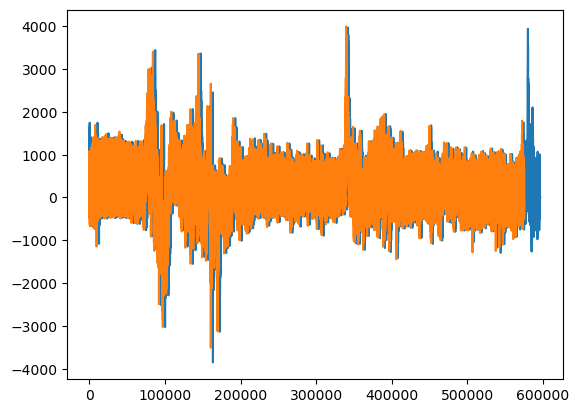

In [1384]:
plt.plot(pd.Series(test))
plt.plot(desired_result['SOT/EKG 3'])

In [1370]:
desired_result['SOT/EKG 3']

0         186.084328
1         170.166961
2         171.312095
3         167.991205
4         167.189611
             ...    
575099    -87.946316
575100    -89.549504
575101    -90.809152
575102    -96.878364
575103    -82.220644
Name: SOT/EKG 3, Length: 575104, dtype: float64

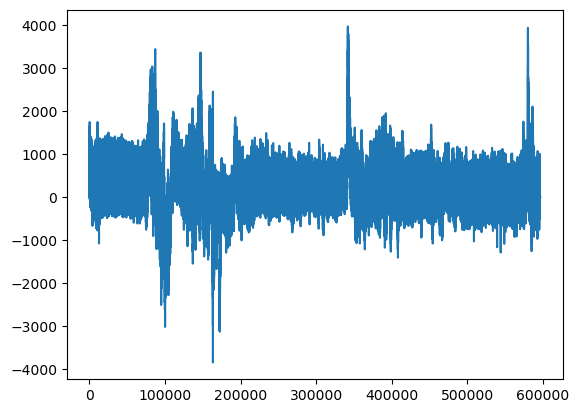

In [1358]:
plt.plot(test)

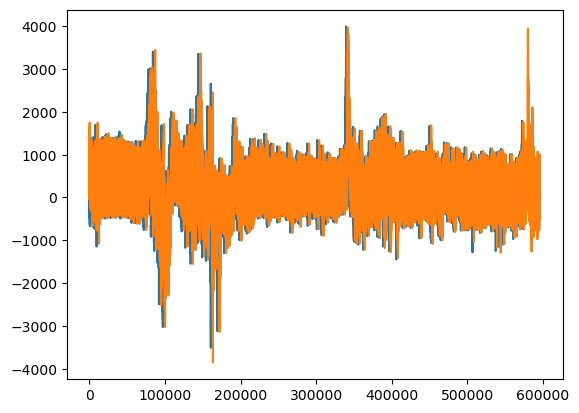

In [1359]:
plt.plot(desired_result['SOT/EKG 3'])
plt.plot(test)

In [ ]:
ECG_correct = np.interp(t, ECG_t - vq, ECG, left=np.nan, right=np.nan)


In [1340]:
ECG=signals['ECG_Raw']

In [1323]:
result_time=ECG_t-vq

In [1338]:
result_time[:213]=ECG_t[:213]

In [1339]:
result_time

0             0.000000
1             0.001513
2             0.003466
3             0.005419
4             0.007372
              ...     
1872891    3647.990283
1872892    3647.992230
1872893    3647.994178
1872894    3647.996126
1872895    3647.998074
Name: time, Length: 1872896, dtype: float64